In [381]:
# A simple MLP implementation that learns multiplication of two numbers

In [382]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy import sqrt
import matplotlib.pyplot as plt

In [383]:
# Dataset class. Prepare the dataset, normalize the inputs and targets, split into training and testing subsets

class MultiDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        
        # Normalize the dataset using Z norm
        self.x = (x - np.mean(x)) / np.std(x) 
        self.y = (y - np.mean(y)) / np.std(y) 
        
        # Alternatively can normalize dividing input and target by their respective max values
        #self.x = x / np.max(x) 
        #self.y = y / np.max(y)
        
        self.x = self.x.astype('float32')
        self.y = self.y.reshape(len(y), 1)
        self.y = self.y.astype('float32')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]
    
    def get_splits(self, n_test = 0.33):
        test_size = round(n_test * len(self.x))
        train_size = len(self.x) - test_size
        
        return torch.utils.data.random_split(self, [train_size, test_size]) 
    
    def prepare_dataset(self):
        train, test = self.get_splits()
        train_dl = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True) # Test with larger batch numbers
        test_dl = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
        
        return train_dl, test_dl
        

In [384]:
# Multi-layer Perceptron model with 3 hidden layers

class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()        
        self.hidden1 = torch.nn.Sequential(torch.nn.Linear(n_inputs, 200), torch.nn.Sigmoid())
        self.hidden2 = torch.nn.Sequential(torch.nn.Linear(200, 100), torch.nn.Sigmoid())        
        self.hidden3 = torch.nn.Sequential(torch.nn.Linear(100, 20), torch.nn.Sigmoid())
        self.output = torch.nn.Sequential(torch.nn.Linear(20,1))
    
    def forward(self, X):
        X = self.hidden1(X)
        X = self.hidden2(X)
        X = self.hidden3(X)
        X = self.output(X)

        return X

In [385]:
# Train the model

def train_model(train_dl, model, num_of_epochs=30):    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Adam optimizer performs better compared to SGD
    
    #optimizer = torch.optim.SGD(model.parameters(), lr=100)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1) # SGD optimizer
    error = [] # Collect errors for plotting
    lrs = []
    model.train()
    
    for epoch in range(1, num_of_epochs+1): # Train for the specified number of epochs
        for i, (inputs, targets) in enumerate(train_dl):        
            optimizer.zero_grad()
            y_hat = model(inputs)
            loss = criterion(y_hat, targets)
            loss.backward()
            optimizer.step()
            
        error.append(np.mean(loss.item())) 
        lrs.append(optimizer.param_groups[0]["lr"])
        #scheduler.step()
        
        if epoch % 5 == 0 or epoch == num_of_epochs-1: # Print loss at every 5th epoch
            print(f"Epoch {epoch}, Loss: {loss.item()}")
        
    plt.plot(error) 
    #plt.plot(lrs) 

In [386]:
# Evaluate the model

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        y_hat = model(inputs)
        y_hat = y_hat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        
        predictions.append(y_hat)
        actuals.append(actual)
        
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    mse = mean_squared_error(actuals, predictions)
    
    return mse

In [387]:
# Predict the output

def predict(row, model):
    row = torch.Tensor([row]) # Convert row to Torch tensor format
    row_norm = (row - np.mean(x)) / np.std(x) # normalise the input using Z norm
    y_hat = model(row_norm)
    y_hat = y_hat.detach().numpy()
    y_hat_norm = np.std(y) * y_hat + np.mean(y) # De-normalise the output 
    
    return y_hat_norm
    

In [388]:
# Initialise the model's linear layer weights

def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [389]:
# Create the dataset containing two numbers as input and multiplication result as output

x = []
y = np.zeros(5000) # sample size

for d in range(len(y)):
    x.append([np.random.randint(1,10), np.random.randint(1,10)]) # Trained on ranges between 0 to 10. 

    y[d] = x[d][0] * x[d][1] 

x = np.array(x)

In [390]:
# Review the dataset

print(f"input: {x[1]}, output: {y[1]}") 

input: [2 5], output: 10.0


In [391]:
dataset = MultiDataset(x, y) # Create ataset class

In [392]:
train_dl, test_dl = dataset.prepare_dataset() # Prepare dataset with train and test subsets

In [393]:
print(len(train_dl), len(test_dl)) # Check the length of training and testing batch sizes

838 105


In [394]:
# Create MLP model with inputs of length 2. Initialize model weights
model = MLP(2) 
init_weights(model)

Epoch 5, Loss: 0.0007800034945830703
Epoch 10, Loss: 0.08529987931251526
Epoch 15, Loss: 0.05285022780299187
Epoch 20, Loss: 4.214355158183025e-06
Epoch 25, Loss: 0.003148031886667013
Epoch 30, Loss: 0.0003848882915917784
Epoch 34, Loss: 9.230915020452812e-05
Epoch 35, Loss: 4.068821453984128e-06


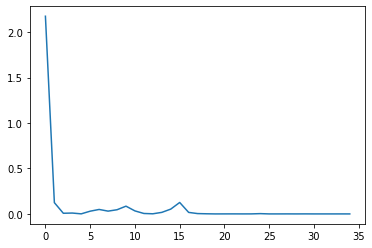

In [395]:
# Train the model for 35 epochs
train_model(train_dl, model, 35) 

In [396]:
# Evaluate the model using mean square error and root mean square error
mse = evaluate_model(test_dl, model) 
print("MSE: %.3f, RMSE: %.3f" % (mse, sqrt(mse)))

MSE: 0.000, RMSE: 0.007


In [397]:
# Test learned multiplication with some random samples 
for g in range(1,11):
    sample = np.array([np.random.randint(1,10), np.random.randint(1,10)])
    predicted = predict(sample, model)
    actual = sample[0] * sample[1]
    print(f'{g} - Input: ({sample[0]}, {sample[1]}). Predicted result: {predicted.item():.3f}, actual: {actual}')

1 - Input: (1, 8). Predicted result: 7.919, actual: 8
2 - Input: (9, 5). Predicted result: 45.147, actual: 45
3 - Input: (7, 4). Predicted result: 28.124, actual: 28
4 - Input: (3, 2). Predicted result: 6.008, actual: 6
5 - Input: (5, 1). Predicted result: 5.170, actual: 5
6 - Input: (3, 1). Predicted result: 3.129, actual: 3
7 - Input: (9, 8). Predicted result: 72.260, actual: 72
8 - Input: (3, 4). Predicted result: 11.929, actual: 12
9 - Input: (9, 6). Predicted result: 54.085, actual: 54
10 - Input: (1, 2). Predicted result: 1.930, actual: 2


In [398]:
# Manually test a sample of numbers between 1-10
print("%.3f " % predict(np.array([20,15]), model).item())

94.566 


In [399]:
model.train()

MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): Sigmoid()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): Sigmoid()
  )
  (output): Sequential(
    (0): Linear(in_features=20, out_features=1, bias=True)
  )
)